In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
import bartz
from stochtree import BARTModel
import time

## Synthetic Data (from [Wu et al. (2007)](https://www.tandfonline.com/doi/abs/10.1198/106186007X180426))

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples per region
n = 100

# Region 1: x1 in [0.1, 0.4], x2 in [0.1, 0.4], x3 in [0.6, 0.9]
x1_r1 = np.random.uniform(0.1, 0.4, n)
x2_r1 = np.random.uniform(0.1, 0.4, n)
x3_r1 = np.random.uniform(0.6, 0.9, n)

# Region 2: x1 in [0.1, 0.4], x2 in [0.6, 0.9], x3 in [0.6, 0.9]
x1_r2 = np.random.uniform(0.1, 0.4, n)
x2_r2 = np.random.uniform(0.6, 0.9, n)
x3_r2 = np.random.uniform(0.6, 0.9, n)

# Region 3: x1 in [0.6, 0.9], x2 in [0.1, 0.9], x3 in [0.1, 0.4]
x1_r3 = np.random.uniform(0.6, 0.9, n)
x2_r3 = np.random.uniform(0.1, 0.9, n)
x3_r3 = np.random.uniform(0.1, 0.4, n)

# Concatenate all
x1 = np.concatenate([x1_r1, x1_r2, x1_r3])
x2 = np.concatenate([x2_r1, x2_r2, x2_r3])
x3 = np.concatenate([x3_r1, x3_r2, x3_r3])

X = np.stack([x1, x2, x3], axis=1)

# Define output y based on the decision rules
def real_y(x):
    x1 = x[0]
    x2 = x[1]
    if x1 <= 0.5:
        if x2 <= 0.5:
            return 1
        else:
            return 3
    else:
        return 5
    
def real_y_vectorized(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    y = np.zeros(X.shape[0])
    y[(x1 <= 0.5) & (x2 <= 0.5)] = 1
    y[(x1 <= 0.5) & (x2 > 0.5)] = 3
    y[x1 > 0.5] = 5
    return y
    
def generate_y(x):
    return real_y(x) + np.random.normal(0, np.sqrt(0.25))

y = np.array([generate_y(row) for row in X])

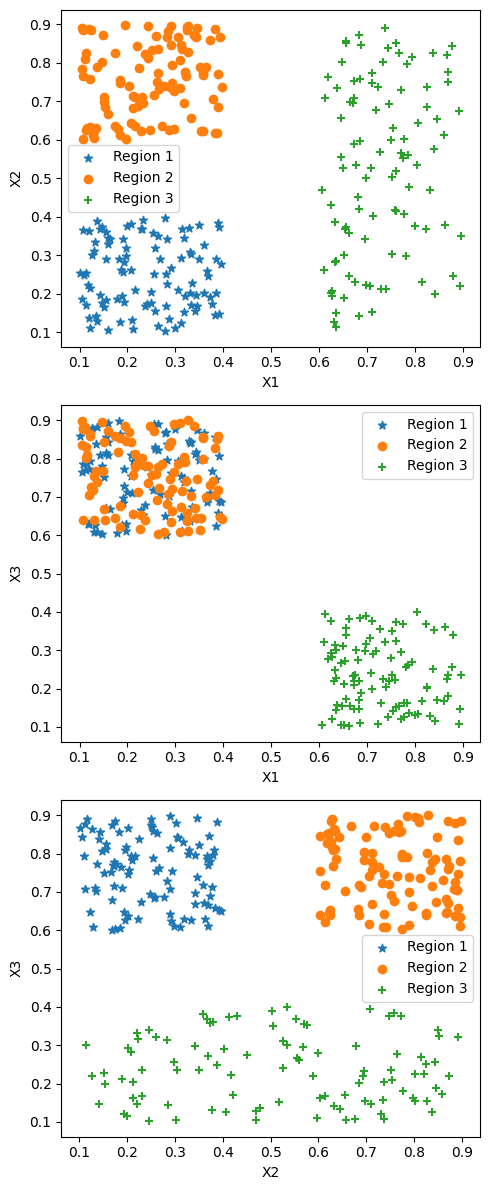

In [3]:
import matplotlib.pyplot as plt

region = np.array([1]*n + [2]*n + [3]*n)
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(5, 12))

# First plot: X1 vs X2
for r, marker in zip([1, 2, 3], ['*', 'o', '+']):
    idx = region == r
    axs[0].scatter(x1[idx], x2[idx], marker=marker, label=f"Region {r}")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")
axs[0].legend()

# Second plot: X1 vs X3
for r, marker in zip([1, 2, 3], ['*', 'o', '+']):
    idx = region == r
    axs[1].scatter(x1[idx], x3[idx], marker=marker, label=f"Region {r}")
axs[1].set_xlabel("X1")
axs[1].set_ylabel("X3")
axs[1].legend()

# Third plot: X2 vs X3
for r, marker in zip([1, 2, 3], ['*', 'o', '+']):
    idx = region == r
    axs[2].scatter(x2[idx], x3[idx], marker=marker, label=f"Region {r}")
axs[2].set_xlabel("X2")
axs[2].set_ylabel("X3")
axs[2].legend()

plt.tight_layout()
plt.show()

In [4]:
test_mse_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto", "rf", "xgb", "lr"]}
train_mse_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto", "rf", "xgb", "lr"]}
pi_length_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto"]}
coverage_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto"]}
time_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto", "rf", "xgb", "lr"]}
oracle_mse_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto", "rf", "xgb", "lr"]}
n_trees_results = []

In [5]:
n_runs = 10
n_post = 1000

n_trees_ini = 100
theta_0_nskip_prop = 0.5
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    y_test_oracle = real_y_vectorized(X_test)
    
    # bart with ChangeNumTreeBART
    t0 = time.time()
    bart_n = ChangeNumTreeBART(ndpost=n_post, nskip=10000, n_trees=n_trees_ini, special_probs = special_probs, 
                               theta_0_ini = n_trees_ini, theta_0_min = 1, theta_0_nskip_prop=theta_0_nskip_prop,
                               tree_num_prior_type="poisson", special_move_interval=5)
    bart_n.fit(X_train, y_train)
    time_results["bart_ntrees"].append(time.time() - t0)

    n_trees = bart_n.trace[-1].n_trees # Use the final number of trees from the trace for the other models
    n_trees_results.append(n_trees)
    n_skip = 200 # Shoule be enough for the other bart models to converge

    # bart with DefaultBART
    t0 = time.time()
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees)
    bart.fit(X_train, y_train)
    time_results["bart_default"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip, printevery=200)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_all_test = np.array(btpred_all_test)
    btpred_test = np.mean(btpred_all_test, axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # sto
    t0 = time.time()
    sto = BARTModel()
    # use a variance forest to enable variance estimation
    sto.sample(X_train=X_train, y_train=y_train,
               num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
               mean_forest_params={"num_trees": n_trees}, variance_forest_params={"num_trees": n_trees // 2})
    sto_pred_all_test, sto_all_sigma = sto.predict(X_test)
    sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    sto_pred_train = np.mean(sto.predict(X_train)[0], axis=1)
    time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=n_trees, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    # lr
    t0 = time.time()
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    time_results["lr"].append(time.time() - t0)
    
    # Test MSE
    test_mse_results["bart_ntrees"].append(mean_squared_error(y_test, bart_n.predict(X_test)))
    test_mse_results["bart_default"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))
    test_mse_results["lr"].append(mean_squared_error(y_test, lr.predict(X_test)))

    # Oracle MSE (noise-free)
    oracle_mse_results["bart_ntrees"].append(mean_squared_error(y_test_oracle, bart_n.predict(X_test)))
    oracle_mse_results["bart_default"].append(mean_squared_error(y_test_oracle, bart.predict(X_test)))
    oracle_mse_results["btz"].append(mean_squared_error(y_test_oracle, btpred_test))
    oracle_mse_results["sto"].append(mean_squared_error(y_test_oracle, sto_pred_test))
    oracle_mse_results["rf"].append(mean_squared_error(y_test_oracle, rf.predict(X_test)))
    oracle_mse_results["xgb"].append(mean_squared_error(y_test_oracle, xgbr.predict(X_test)))
    oracle_mse_results["lr"].append(mean_squared_error(y_test_oracle, lr.predict(X_test)))

    # Train MSE
    train_mse_results["bart_ntrees"].append(mean_squared_error(y_train, bart_n.predict(X_train)))
    train_mse_results["bart_default"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))
    train_mse_results["lr"].append(mean_squared_error(y_train, lr.predict(X_train)))

    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    eps = np.zeros_like(btpred_all_test)
    for i in range(n_post):
        eps[i] = np.random.normal(0, btz.sigma[i], size=btpred_all_test.shape[1])
        btpred_all_test[i, :] += eps[i]    
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    btz_covered = ((y_test >= btz_lower) & (y_test <= btz_upper)).mean()
    coverage_results["btz"].append(btz_covered)
    
    # sto: axis=1, shape (n_test, n_mcmc)
    sto_eps = np.zeros_like(sto_pred_all_test)
    for i in range(n_post):
        sto_eps[:, i] = np.random.normal(np.zeros(sto_pred_all_test.shape[0]), sto_all_sigma[:, i])
        sto_pred_all_test[:, i] += sto_eps[:, i]
    sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    sto_covered = ((y_test >= sto_lower) & (y_test <= sto_upper)).mean()
    coverage_results["sto"].append(sto_covered)
    
    # bart_ntrees: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart_n.posterior_predict(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart_ntrees"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart_ntrees"].append(bart_covered)

    # bart_default: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_predict(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart_default"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart_default"].append(bart_covered)

Iterations: 100%|██████████| 1200/1200 [00:01<00:00, 626.31it/s]
INFO:2025-06-09 16:10:20,992:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-09 16:10:20,992:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration  200/1200 P_grow=1.00 P_prune=0.00 A_grow=0.25 A_prune=nan (burnin)
Iteration  400/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.33
Iteration  600/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration  800/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.33
Iteration 1000/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.50
Iteration 1200/1200 P_grow=0.50 P_prune=0.50 A_grow=0.50 A_prune=0.00


Iterations: 100%|██████████| 1200/1200 [00:02<00:00, 408.54it/s]


Iteration  200/1200 P_grow=0.70 P_prune=0.30 A_grow=0.43 A_prune=0.67 (burnin)
Iteration  400/1200 P_grow=0.50 P_prune=0.50 A_grow=0.20 A_prune=0.60
Iteration  600/1200 P_grow=0.60 P_prune=0.40 A_grow=0.67 A_prune=0.25
Iteration  800/1200 P_grow=0.30 P_prune=0.70 A_grow=0.00 A_prune=0.57
Iteration 1000/1200 P_grow=0.60 P_prune=0.40 A_grow=0.00 A_prune=0.25
Iteration 1200/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.40


Iterations: 100%|██████████| 1200/1200 [00:02<00:00, 461.50it/s]


Iteration  200/1200 P_grow=0.56 P_prune=0.44 A_grow=0.20 A_prune=0.25 (burnin)
Iteration  400/1200 P_grow=0.89 P_prune=0.11 A_grow=0.25 A_prune=1.00
Iteration  600/1200 P_grow=0.56 P_prune=0.44 A_grow=0.40 A_prune=0.25
Iteration  800/1200 P_grow=0.44 P_prune=0.56 A_grow=0.50 A_prune=0.20
Iteration 1000/1200 P_grow=0.44 P_prune=0.56 A_grow=0.00 A_prune=0.60
Iteration 1200/1200 P_grow=0.44 P_prune=0.56 A_grow=0.00 A_prune=0.20


Iterations: 100%|██████████| 1200/1200 [00:01<00:00, 1004.24it/s]


Iteration  200/1200 P_grow=1.00 P_prune=0.00 A_grow=0.00 A_prune=nan (burnin)
Iteration  400/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.00
Iteration  600/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration  800/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.33
Iteration 1000/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration 1200/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00


Iterations: 100%|██████████| 1200/1200 [00:02<00:00, 475.46it/s]


Iteration  200/1200 P_grow=0.33 P_prune=0.67 A_grow=0.00 A_prune=0.50 (burnin)
Iteration  400/1200 P_grow=0.67 P_prune=0.33 A_grow=0.25 A_prune=0.00
Iteration  600/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration  800/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.33
Iteration 1000/1200 P_grow=0.17 P_prune=0.83 A_grow=0.00 A_prune=0.20
Iteration 1200/1200 P_grow=0.00 P_prune=1.00 A_grow=nan A_prune=0.17


Iterations: 100%|██████████| 1200/1200 [00:01<00:00, 1053.29it/s]


Iteration  200/1200 P_grow=1.00 P_prune=0.00 A_grow=0.00 A_prune=nan (burnin)
Iteration  400/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.33
Iteration  600/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.50
Iteration  800/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.33
Iteration 1000/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration 1200/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00


Iterations: 100%|██████████| 1200/1200 [00:03<00:00, 337.50it/s]


Iteration  200/1200 P_grow=0.42 P_prune=0.58 A_grow=0.20 A_prune=0.29 (burnin)
Iteration  400/1200 P_grow=0.67 P_prune=0.33 A_grow=0.50 A_prune=0.00
Iteration  600/1200 P_grow=0.67 P_prune=0.33 A_grow=0.25 A_prune=0.50
Iteration  800/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.50
Iteration 1000/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.22
Iteration 1200/1200 P_grow=0.58 P_prune=0.42 A_grow=0.00 A_prune=0.20


Iterations: 100%|██████████| 1200/1200 [00:01<00:00, 940.08it/s] 


Iteration  200/1200 P_grow=1.00 P_prune=0.00 A_grow=0.00 A_prune=nan (burnin)
Iteration  400/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.00
Iteration  600/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration  800/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.00
Iteration 1000/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration 1200/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.50


Iterations: 100%|██████████| 1200/1200 [00:01<00:00, 813.47it/s]


Iteration  200/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00 (burnin)
Iteration  400/1200 P_grow=1.00 P_prune=0.00 A_grow=0.00 A_prune=nan
Iteration  600/1200 P_grow=0.00 P_prune=1.00 A_grow=nan A_prune=0.00
Iteration  800/1200 P_grow=0.00 P_prune=1.00 A_grow=nan A_prune=0.50
Iteration 1000/1200 P_grow=0.50 P_prune=0.50 A_grow=1.00 A_prune=0.00
Iteration 1200/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00


Iterations: 100%|██████████| 1200/1200 [00:01<00:00, 944.31it/s]


Iteration  200/1200 P_grow=1.00 P_prune=0.00 A_grow=0.00 A_prune=nan (burnin)
Iteration  400/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.00
Iteration  600/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.50
Iteration  800/1200 P_grow=0.25 P_prune=0.75 A_grow=0.00 A_prune=0.33
Iteration 1000/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration 1200/1200 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00


In [6]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
coverage_df = pd.DataFrame(coverage_results)
time_df = pd.DataFrame(time_results)
oracle_mse_df = pd.DataFrame(oracle_mse_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Oracle MSE Mean:")
print(oracle_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Prediction Interval Coverage Mean ({n_runs} runs):")
print(coverage_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

print(f"Number of Trees (after shrinkage) in {n_runs} runs: {n_trees_results}")

Test MSE (10 runs):
Train MSE (10 runs):
Test MSE Mean:
bart_ntrees     0.287059
bart_default    0.297234
btz             0.257252
sto             0.251762
rf              0.349632
xgb             0.463731
lr              0.640599
dtype: float64
Oracle MSE Mean:
bart_ntrees     0.039127
bart_default    0.036744
btz             0.016357
sto             0.012012
rf              0.094720
xgb             0.216757
lr              0.403699
dtype: float64
Train MSE Mean:
bart_ntrees     0.209689
bart_default    0.205321
btz             0.213563
sto             0.213478
rf              0.073061
xgb             0.280328
lr              0.645322
dtype: float64
Prediction Interval Mean Length (10 runs):
Prediction Interval Mean Length (Mean over 10 runs):
bart_ntrees     1.981781
bart_default    1.971818
btz             1.895529
sto             1.931934
dtype: float64
Prediction Interval Coverage Mean (10 runs):
bart_ntrees     0.948000
bart_default    0.938667
btz             0.942667
sto       

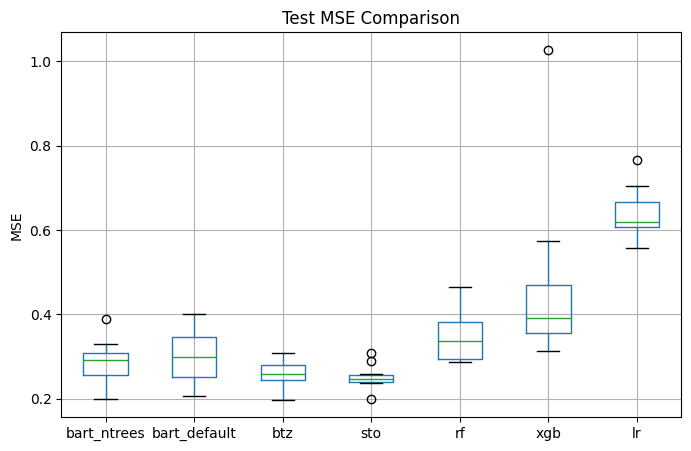

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

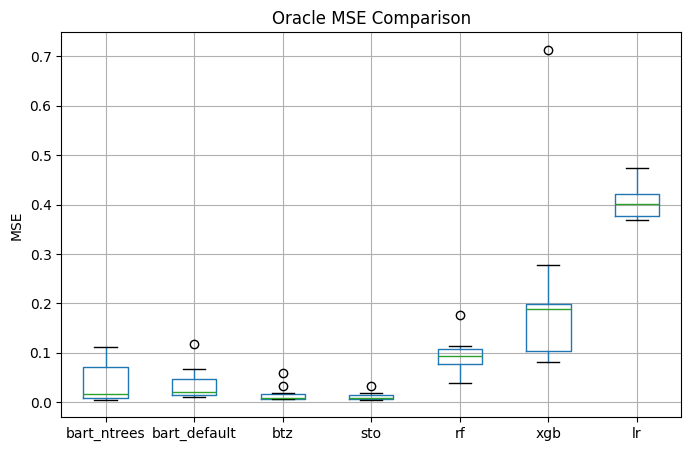

In [8]:
plt.figure(figsize=(8, 5))
oracle_mse_df.boxplot()
plt.title("Oracle MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

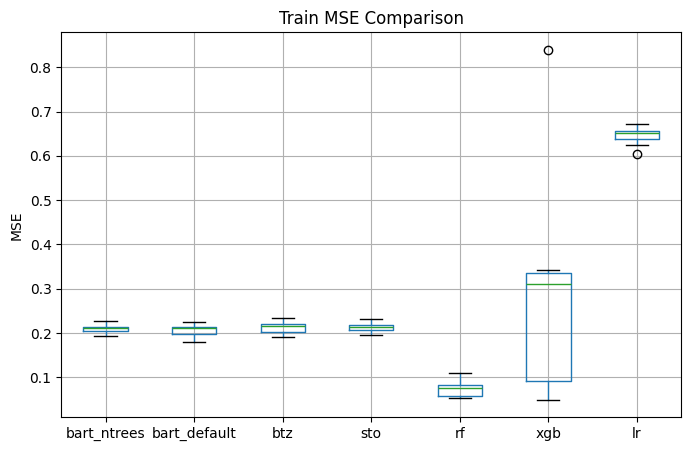

In [9]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

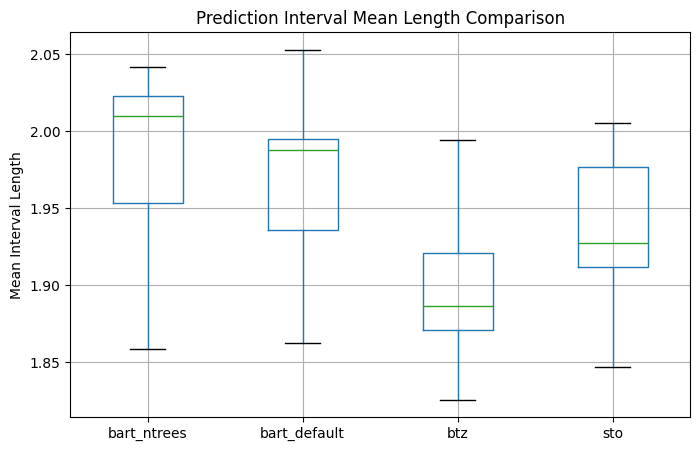

In [10]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

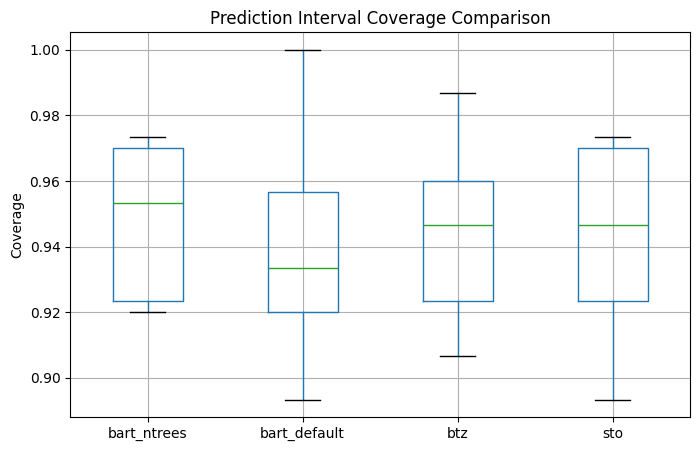

In [11]:
plt.figure(figsize=(8, 5))
coverage_df.boxplot()
plt.title("Prediction Interval Coverage Comparison")
plt.ylabel("Coverage")
plt.grid(True, axis='y')
plt.show()

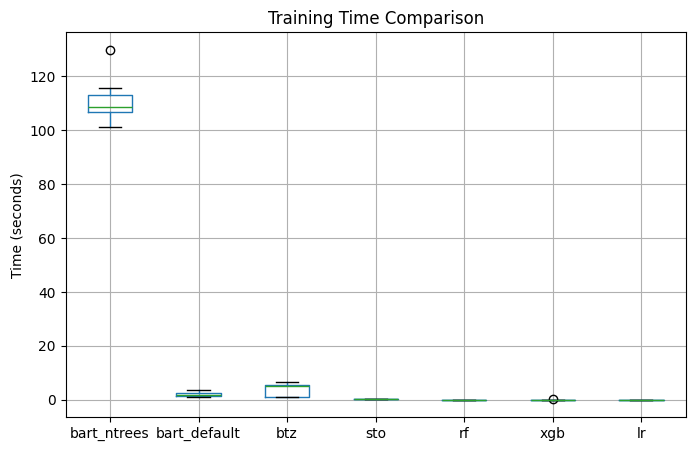

In [12]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()